In [ ]:
!pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu121 -U

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 795.7/795.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 814.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━

# Summary:
* ## Tensor Subclasses
* ## TorchDispatchModes
* ## FakeTensors
* ## Profiling Memory
* ## Computing FLOPS
* ## Integration With torch.compile
* ## Complex Tensors





# What is `__torch__dispatch__` ?


torch_dispatch allows you to arbitrarily extend PyTorch with all the power of the dispatcher, but now from Python. This will hopefully open up a whole new frontier of flexibility for PyTorch.

With torch_dispatch you can interpret PyTorch code with custom functionality. It operates below Autograd and Autocast in the dispatcher so you do not need to recreate these complex systems. In the same way you can run model code with either float32 or float16 tensors, cuda or cpu, you can now extend it with custom datatypes or semantics.

For more background, read [horace's explainer.](https://dev-discuss.pytorch.org/t/what-and-why-is-torch-dispatch/557)

There are two ways to use `__torch__dispatch__`:
* ##  Tensor Subclasses
* ## TorchDispatchModes


In [ ]:
import torch

def foo(x):
    y = x @ x
    return y + torch.rand(y.shape, device=y.device)

In [ ]:
# Tensor Subclass
from torch.utils._mode_utils import no_dispatch
from torch.utils._pytree import tree_map_only

class LoggingTensor(torch.Tensor):
    @staticmethod
    def __new__(cls, elem):
        return torch.Tensor._make_subclass(cls, elem, elem.requires_grad)

    def __repr__(self):
        with no_dispatch():
            self_repr = super().__repr__()
        return f"LoggingTensor: {self_repr}"

    @classmethod
    def __torch_dispatch__(cls, func, types, args=(), kwargs=None):
        # here is where we add custom functionality

        print(f"{func}") # omitting args for breivy
        out = func(*args, **kwargs)

        return tree_map_only(torch.Tensor, LoggingTensor, out)


In [ ]:
x = LoggingTensor(torch.rand([2, 2], requires_grad=True))
foo(x)

# rand will not be captured, since it is a constructor

aten.mm.default
aten.add.Tensor


LoggingTensor: LoggingTensor([[0.9181, 1.2305],
               [1.0794, 0.2732]], grad_fn=<AddBackward0>)

In [ ]:
# Tensor Modes
from torch.utils._python_dispatch import TorchDispatchMode

class LoggingMode(TorchDispatchMode):
    def __torch_dispatch__(self, func, types, args, kwargs=None):
        print(f"{func}")
        return func(*args, **kwargs)

In [ ]:
# captures constructors too
with LoggingMode():
    out = foo(torch.rand([2, 2], requires_grad=True))


aten.rand.default
aten.mm.default
aten.rand.default
aten.add.Tensor


In [ ]:
# both subclasses and modes also capture the backward
with LoggingMode():
    out.sum().backward()

aten.sum.default
aten.ones_like.default
aten.expand.default
aten.t.default
aten.mm.default
aten.t.default
aten.mm.default
aten.add.Tensor
aten.detach.default
aten.detach.default


# FakeTensors: Tensors without Data

FakeTensors are a `__torch__dispatch__` subclass that trace out tensor operations without actually doing computation. Fake Tensors are comprised of a **meta tensor** and a **fake device**. Running your code with fake tensor should completely replicate all of the properties you would get running with their real counterparts - sizes, strides, aliasing, etc. They were first implemented outside of tree [in torchdistx](https://pytorch.org/torchdistx/latest/fake_tensor.html) but have reimplemented to take advantage of `__torch_dispatch__` and in python for flexibility.

Fake Tensors are used throughout PyTorch 2.0 to trace through PyTorch without actually running operators on real tensors, and to persist type information on FX Graphs

For any use case where you like to abstract analysis on the operators and tensors of your model, we encourage FakeTensors. Here, we are going to focus on a couple of example use cases.


###  Detecting Shape or Broadcasting Errors Quickly and Without Side Effects

* Instead of waiting many slow kernels to reach a shape error, run it with fake tensors (speed is actually wip)
* Not quite [statically checked shapes](https://github.com/pytorch/pytorch/issues/26889) - but maybe as close as we will get





In [ ]:
import torchvision.models as models
from torch._subclasses import FakeTensorMode

resnext50_32x4d = models.resnext50_32x4d(pretrained=False)

# Run a few iterations of a model to quickly detect shape errors
def check_errors(inp):
    with FakeTensorMode(allow_non_fake_inputs=True):
        print(resnext50_32x4d(inp).sum().backward())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
check_errors(torch.rand([8, 1, 255, 255], requires_grad=True))

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[8, 1, 255, 255] to have 3 channels, but got 1 channels instead

In [ ]:
check_errors(torch.rand([8, 3, 255, 255], requires_grad=True))

None


### Computing Maximum Batch Size

* To compute the maximum batch size we will run the network and record the maximum live (fake) memory allocated to Fake Tensors
* We can use another TorchDispatchMode - they are composable - to compute maximum live memory
* Note: in practice maximum batch size may be slightly less due to memory fragmentation in the allocator, cuDNN workspace tuning, or intermediate allocations internal to ops

In [ ]:
from collections import Counter
import functools
import weakref
from typing import Dict

import torch
from torch._dispatch.python import enable_python_dispatcher
from torch._subclasses import FakeTensorMode
from torch.utils._python_dispatch import TorchDispatchMode
from torch.utils._pytree import tree_map_only
import torchvision.models as models

In [ ]:
class TensorMemoryProfilerMode(TorchDispatchMode):
    def __init__(self):
        # counter of storage ids to live references
        self.live_storages = weakref.WeakKeyDictionary()
        self.memory_use = 0
        self.max_memory = 0

    def __torch_dispatch__(self, func, types, args=(), kwargs=None):
        kwargs = kwargs if kwargs is not None else {}
        rs = func(*args, **kwargs)
        tree_map_only(torch.Tensor, self.track_tensor_memory_use, rs)
        return rs

    def track_tensor_memory_use(self, tensor):
        # already accounted for
        stor = tensor.untyped_storage()
        if stor in self.live_storages:
            return

        self.live_storages[stor] = True
        nbytes = tensor.untyped_storage().nbytes()

        # new storage, add to memory
        self.change_memory(nbytes)

        # when this storage dies, we need to adjust memory
        weakref.finalize(stor, functools.partial(self.change_memory, -nbytes))

    def change_memory(self, delta):
        self.memory_use += delta
        self.max_memory = max(self.memory_use, self.max_memory)

In [ ]:
MB = 2 ** 20
GB = 2 ** 30

MEMORY_LIMIT = 16 * GB

def fn(batch_size):
    print(f"Running batch size {batch_size}")
    with FakeTensorMode(), enable_python_dispatcher():
        with TensorMemoryProfilerMode() as tmpm:
            resnext50_32x4d = models.resnext50_32x4d(pretrained=False)
            output = resnext50_32x4d(torch.rand([batch_size, 3, 255, 255], requires_grad=True))
            print(f"GB after forward: {tmpm.max_memory / GB}")
            output.sum().backward()
            print(f"GB after backward: {tmpm.max_memory / GB}")
            return tmpm.max_memory

In [ ]:
def binary_search_batch_size(fn, curr, max_good=0, min_bad=None):
    mem = fn(curr)
    if mem <= MEMORY_LIMIT:
        if min_bad is not None and curr == min_bad - 1:
            return curr
        else:
            next_iter = curr * 2 if min_bad is None else (min_bad + curr) // 2
            return binary_search_batch_size(fn, next_iter, curr, min_bad)
    else:
        if curr == max_good + 1:
            return max_good
        else:
            next_iter = (max_good + curr) // 2
            return binary_search_batch_size(fn, next_iter, max_good, curr)


In [ ]:
import warnings

# ignore torchvision warnings
warnings.filterwarnings("ignore")

print(f"\nMaximum Batch Size: {binary_search_batch_size(fn, 1)}\n")

Running batch size 1
GB after forward: 0.23022888973355293
GB after backward: 0.29162636026740074
Running batch size 2
GB after forward: 0.3667091429233551
GB after backward: 0.42011863738298416
Running batch size 4
GB after forward: 0.6396696493029594
GB after backward: 0.6857244074344635
Running batch size 8
GB after forward: 1.1855906620621681
GB after backward: 1.2198961526155472
Running batch size 16
GB after forward: 2.2774326875805855
GB after backward: 2.307786151766777
Running batch size 32
GB after forward: 4.46111673861742
GB after backward: 4.499755725264549
Running batch size 64
GB after forward: 8.82848484069109
GB after backward: 8.898129686713219
Running batch size 128
GB after forward: 17.56322104483843
GB after backward: 17.694877609610558
Running batch size 96
GB after forward: 13.195852942764759
GB after backward: 13.296503648161888
Running batch size 112
GB after forward: 15.379536993801594
GB after backward: 15.495690628886223
Running batch size 120
GB after forwa

For further memory resources I recommmend https://zdevito.github.io/2022/08/16/memory-snapshots.html and https://github.com/albanD/subclass_zoo/blob/main/dispatch_mem_profiler.py




## Leveraging Dynamic Shapes in PyTorch 2 Computing Max Batch Size

Dynamic shapes are deeply integrated into PyTorch 2. We can create a dynamic batch size to explicitly calculate memory as a function of batch size. Dynamic shapes, like the rest of PT2, are tracing based. Control flow or assertions add constraints to their values.


In this example, the final output code is valid given the specialization x.shape[0] > y.shape[0]. Similarly, our memory formulas may be valid given a specialization.

In [ ]:
import torch
torch._logging.set_logs(dynamic=20)

@torch.compile(dynamic=True)
def foo(x, y):
    x_first_dim = x.shape[0]

    if x.shape[0] > y.shape[0]:
        max_first_dim = y.shape[0]
    else:
        max_first_dim = x.shape[0]

    return x + max_first_dim

foo(torch.randn(10), torch.randn(5))

[2024-04-27 19:54:08,885] [0/0] torch.fx.experimental.symbolic_shapes: [INFO] create_env
[2024-04-27 19:54:08,951] [0/0] torch.fx.experimental.symbolic_shapes: [INFO] create_symbol s0 = 10 for L['x'].size()[0] [2, 9223372036854775806]
[2024-04-27 19:54:08,963] [0/0] torch.fx.experimental.symbolic_shapes: [INFO] create_symbol s1 = 5 for L['y'].size()[0] [2, 9223372036854775806]
[2024-04-27 19:54:08,974] [0/0] torch.fx.experimental.symbolic_shapes: [INFO] eval s0 > s1 [guard added] at <ipython-input-7-1ae55a32ee35>:8 in foo (_dynamo/variables/tensor.py:806 in evaluate_expr)
[2024-04-27 19:54:18,680] [0/0] torch.fx.experimental.symbolic_shapes: [INFO] produce_guards


tensor([4.9382, 5.0380, 4.5607, 2.3631, 3.9123, 6.4277, 5.9064, 4.7665, 5.4926,
        5.0786])

In [ ]:
# Define some utilities and imports

from torch import SymInt
from torch.fx.experimental.symbolic_shapes import (
    DimDynamic,
    ShapeEnv,
)
import sympy
from torch.fx.experimental.sym_node import SymNode

def create_symtype(cls, pytype, shape_env, val, duck=True):
    from torch._dynamo.source import ConstantSource

    symbol = shape_env.create_symbol(
        val,
        source=ConstantSource(f"__testing_only{len(shape_env.var_to_val)}"),
        dynamic_dim=DimDynamic.DUCK if duck else DimDynamic.DYNAMIC,
        constraint_dim=None,
    )
    return cls(
        SymNode(
            symbol,
            shape_env,
            pytype,
            hint=val,
        )
    )


def create_symint(shape_env, i: int, duck=True):
    return create_symtype(SymInt, int, shape_env, i, duck=duck)


In [ ]:
# Create a symbolic batch size, then solve for maximum memory

def compute_max_memory(batch_size_hint):
  shape_env = ShapeEnv()
  fake_mode = torch._subclasses.FakeTensorMode(shape_env=shape_env)
  with fake_mode, enable_python_dispatcher():
      with TensorMemoryProfilerMode() as tmpm:
          batch_size = create_symint(fake_mode.shape_env, batch_size_hint)
          resnext50_32x4d = models.resnext50_32x4d(pretrained=False)
          output = resnext50_32x4d(torch.rand([batch_size, 3, 255, 255], requires_grad=True))
          print(f"GB after forward: {tmpm.max_memory / GB}")
          output.sum().backward()
          print(f"GB after backward: {tmpm.max_memory / GB}")
          max_memory = tmpm.max_memory

  max_memory = max_memory.node.expr
  print(max_memory)
  solution = sympy.solveset(max_memory <= MEMORY_LIMIT, next(iter(max_memory.free_symbols)), domain=sympy.Reals)
  print(solution.right // 1)

compute_max_memory(4)

[2024-04-27 19:54:24,482] torch.fx.experimental.symbolic_shapes: [INFO] create_env
[2024-04-27 19:54:24,488] torch.fx.experimental.symbolic_shapes: [INFO] create_symbol s0 = 4 for __testing_only0 [2, 9223372036854775806]
[2024-04-27 19:54:25,226] torch.fx.experimental.symbolic_shapes: [INFO] eval s0 < 16 [guard added] (_subclasses/fake_tensor.py:765 in conv)
[2024-04-27 19:54:26,291] torch.fx.experimental.symbolic_shapes: [INFO] eval 147584940*s0 + 108857840 <= 146798508*s0 + 117246448 [guard added] (<ipython-input-3-a9973e854cf2>:31 in change_memory)
[2024-04-27 19:54:26,370] torch.fx.experimental.symbolic_shapes: [INFO] eval 146798508*s0 + 117246448 <= 145749932*s0 + 126814704 [guard added] (<ipython-input-3-a9973e854cf2>:31 in change_memory)
[2024-04-27 19:54:26,407] torch.fx.experimental.symbolic_shapes: [INFO] eval 146012076*s0 + 126814704 <= 144701356*s0 + 135203312 [guard added] (<ipython-input-3-a9973e854cf2>:31 in change_memory)


GB after forward: 36636139*s0/268435456 + 12582729/134217728


[2024-04-27 19:54:26,474] torch.fx.experimental.symbolic_shapes: [INFO] eval 144701356*s0 + 135203312 <= 143652780*s0 + 144771568 [guard added] (<ipython-input-3-a9973e854cf2>:31 in change_memory)
[2024-04-27 19:54:26,537] torch.fx.experimental.symbolic_shapes: [INFO] eval 143390636*s0 + 153176560 <= 142604204*s0 + 161548784 [guard added] (<ipython-input-3-a9973e854cf2>:31 in change_memory)
[2024-04-27 19:54:26,604] torch.fx.experimental.symbolic_shapes: [INFO] eval 143390636*s0 + 162728432 > 141293484*s0 + 166922736 [guard added] (<ipython-input-3-a9973e854cf2>:31 in change_memory)


GB after backward: 35847659*s0/268435456 + 10170527/67108864
143390636*s0 + 162728432
118


The answer we get 118 is different than previously. In order to trace through the memory calculation, we added guards. So our max memory calculation is only valid given batch size < 16.

In [ ]:
compute_max_memory(16)

[2024-04-27 19:54:33,800] torch.fx.experimental.symbolic_shapes: [INFO] create_env
[2024-04-27 19:54:33,807] torch.fx.experimental.symbolic_shapes: [INFO] create_symbol s0 = 16 for __testing_only0 [2, 9223372036854775806]
[2024-04-27 19:54:34,308] torch.fx.experimental.symbolic_shapes: [INFO] eval s0 >= 16 [guard added] (_subclasses/fake_tensor.py:765 in conv)


GB after forward: 36636139*s0/268435456 + 12582729/134217728
GB after backward: 36896235*s0/268435456 + 6803615/67108864
147584940*s0 + 108857840
115


Now we see both the correct answer, and only the single guard `s0 >= 16`, so we can be confident we are correctly computing maximum batch size given it is at least 16.

# Computing Symbolic Flop Formulas

As one last example, we will use [FlopCounterMode](https://dev-discuss.pytorch.org/t/the-ideal-pytorch-flop-counter-with-torch-dispatch/505) to compute symbolic flop formulas of GPT.

In [ ]:
!git clone https://github.com/karpathy/nanoGPT
%cd nanoGPT

Cloning into 'nanoGPT'...
remote: Enumerating objects: 671, done.
remote: Total 671 (delta 0), reused 0 (delta 0), pack-reused 671
Receiving objects: 100% (671/671), 947.92 KiB | 3.17 MiB/s, done.
Resolving deltas: 100% (379/379), done.
/content/nanoGPT


In [ ]:
from model import GPTConfig, GPT
from torch.utils.flop_counter import FlopCounterMode

In [ ]:
def analyze_model(model, fake_mode):
    batch_size = create_symint(fake_mode.shape_env, 4)
    input_size = create_symint(fake_mode.shape_env, 128)
    input_data = torch.randint(
        0, model.config.vocab_size, (batch_size, input_size), dtype=torch.long
    )

    with FlopCounterMode(model, display=False) as flop_mode:
        model.generate(input_data, max_new_tokens=1)

    return flop_mode.get_total_flops()

shape_env = ShapeEnv()
with torch._subclasses.FakeTensorMode(
    shape_env=shape_env
) as fake_mode, enable_python_dispatcher():
    model_configs = [
        GPTConfig(n_layer=12, n_head=12, n_embd=768),   # GPT-2 (small)
        GPTConfig(n_layer=24, n_head=16, n_embd=1024),  # GPT-2 (medium)
        GPTConfig(n_layer=36, n_head=20, n_embd=1280),  # GPT-2 (large)
        GPTConfig(n_layer=48, n_head=25, n_embd=1600),  # GPT-2 (XL)
    ]

    # Iterate over the model configurations
    for config in model_configs:
        model = GPT(config)
        model.cpu().eval()

        print(
            f"Model: GPT-2 ({config.n_layer} layers, {config.n_head} heads, {config.n_embd} embedding dim)"
        )

        flop_formula = analyze_model(model, fake_mode)
        print(f"Flop formula {flop_formula}")


I0427 18:40:15.897000 132140477829120 torch/fx/experimental/symbolic_shapes.py:3132] create_symbol s0 = 4 for __testing_only0 [2, 9223372036854775806] (<ipython-input-20-833c7729fc09>:14 in create_symtype), for more info run with TORCHDYNAMO_EXTENDED_DEBUG_CREATE_SYMBOL="s0"
I0427 18:40:15.901000 132140477829120 torch/fx/experimental/symbolic_shapes.py:3132] create_symbol s1 = 128 for __testing_only1 [2, 9223372036854775806] (<ipython-input-20-833c7729fc09>:14 in create_symtype), for more info run with TORCHDYNAMO_EXTENDED_DEBUG_CREATE_SYMBOL="s1"
I0427 18:40:15.915000 132140477829120 torch/fx/experimental/symbolic_shapes.py:4516] eval s1 <= 1024 [guard added] (ontent/nanoGPT/model.py:314 in generate), for more info run with TORCHDYNAMO_EXTENDED_DEBUG_GUARD_ADDED="s1 <= 1024"


number of parameters: 123.69M
Model: GPT-2 (12 layers, 12 heads, 768 embedding dim)
Flop formula 169869312*s0*s1 + 77266944*s0
number of parameters: 353.82M
Model: GPT-2 (24 layers, 16 heads, 1024 embedding dim)
Flop formula 603979776*s0*s1 + 103022592*s0
number of parameters: 772.78M
Model: GPT-2 (36 layers, 20 heads, 1280 embedding dim)
Flop formula 1415577600*s0*s1 + 128778240*s0
number of parameters: 1556.05M
Model: GPT-2 (48 layers, 25 heads, 1600 embedding dim)
Flop formula 2949120000*s0*s1 + 160972800*s0


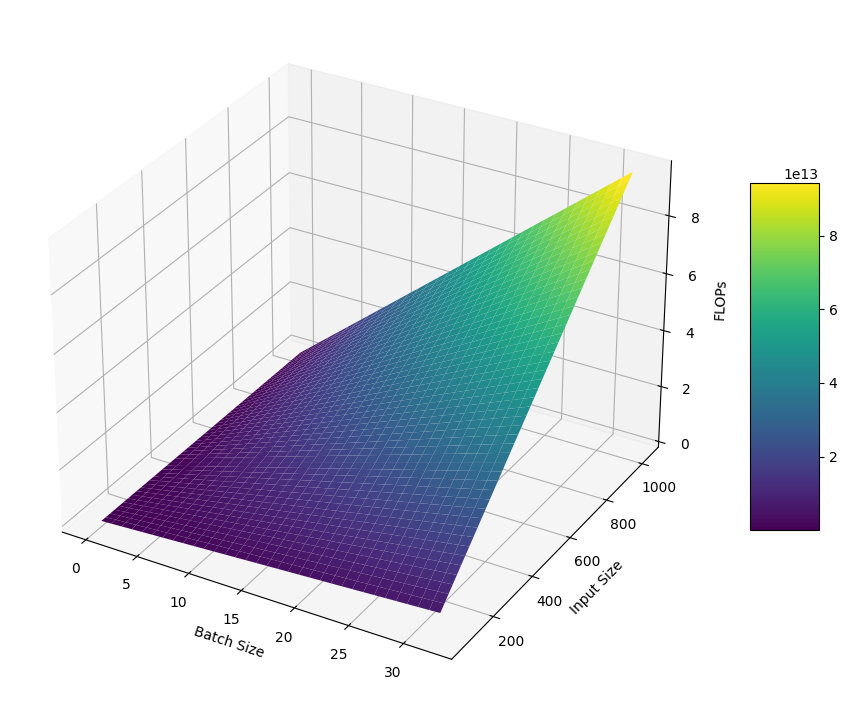

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sympy import lambdify
f = flop_formula.node.expr
f_lambdified = lambdify(list(f.free_symbols), f, "numpy")

s0_values = np.arange(0, 33, 1)  # batch sizes from 0 to 32
s1_values = np.arange(64, 1025, 1)  # input sizes from 64 to 1024
# Create a meshgrid for s0 and s1
s0_grid, s1_grid = np.meshgrid(s0_values, s1_values)
# Calculate the function values
z_values = f_lambdified(s0_grid, s1_grid)
# Create the plot
fig = plt.figure(figsize=(12, 9))
ax = plt.axes(projection="3d")
surf = ax.plot_surface(s0_grid, s1_grid, z_values, cmap='viridis')
fig.colorbar(surf, shrink=0.5, aspect=5)  # Add a color bar which maps values to colors.
ax.set_xlabel('Batch Size')
ax.set_ylabel('Input Size')
ax.set_zlabel('FLOPs')
plt.show()


# Tensor Subclasses: Integration with torch.compile

## What does it mean to compile a subclass?

Answer: we trace *inside* of your __torch_dispatch__ implementation in order to trace out a graph.

* Subclasses as an extension point: override the behavior of every operator to do **something else** (call another operator)
* torch.compile integration: Trace that **something else** into a graph

If your subclass turns `aten.add` into `aten.sub`, the graph we will trace out

## Are there any restrictions on what you can do in your subclass?

Answer: Yes!

Mental model:
* Your subclass is a wrapper that holds some inner tensor(s).
* Your subclass's __torch_dispatch__ implementation will call into more operators on its inner tensors, that we will trace out into a graph
* your implementation must be "traceable" (only call into other operators, no 3rd party libs, no using global state)

Some examples of subclasses / modes that do **not** work with compile (they do not "desugar into more operators that we can trace into a graph").
* FlopCounter
* LoggingTensor

AOTAutograd is the component in torch.compile that traces into tensor subclasses. Link to AOTAutograd slides: https://docs.google.com/presentation/d/1vD5X4u6Mme6Ivm0POwMLYXxp4mea5tlPeI7BVyL7_ow/edit?usp=sharing

# Basic Example

Simple subclass that adds a constant K to the output of every call to torch.mul

"Subclass desugaring" here: inserts extra `add` calls into the graph

In [ ]:
import torch
import torch.utils._pytree as pytree
from torch.utils._python_dispatch import return_and_correct_aliasing

INCLUDED_OPS = [
    torch.ops.aten.mul.Tensor,
    torch.ops.aten.mul.Scalar,
]

# A simple tensor subclass that adds a constant to every tensor output
class PlusKTensor(torch.Tensor):
    @staticmethod
    def __new__(cls, elem, k):
        assert isinstance(k, int)
        shape = elem.shape
        kwargs = {}
        kwargs["strides"] = elem.stride()
        kwargs["storage_offset"] = elem.storage_offset()
        kwargs["device"] = elem.device
        kwargs["layout"] = elem.layout
        kwargs["requires_grad"] = elem.requires_grad
        kwargs["dtype"] = elem.dtype
        out = torch.Tensor._make_wrapper_subclass(cls, shape, **kwargs)
        return out

    def __init__(self, elem, k):
        self.elem = elem
        self.k = k

    def __repr__(self):
        return f"PlusKTensor({repr(self.elem)}, k={self.k})"

    def __tensor_flatten__(self):
        return ["elem"], self.k

    @staticmethod
    def __tensor_unflatten__(inner_tensors, meta, outer_size, outer_stride):
        assert isinstance(meta, int)
        k = meta
        elem = inner_tensors["elem"]
        return PlusKTensor(elem, k)

    @classmethod
    def __torch_dispatch__(cls, func, types, args, kwargs):
        if kwargs is None:
            kwargs = {}

        # Assume at least one of our args is a PlusKTensor
        # Find it and grab its constant to propagate it to the output
        k = next(iter([x for x in pytree.tree_flatten(args)[0] if isinstance(x, PlusKTensor)])).k
        args_inner = pytree.tree_map_only(PlusKTensor, lambda x: x.elem, args)
        kwargs_inner = pytree.tree_map_only(PlusKTensor, lambda x: x.elem, kwargs)

        out_inner = func(*args_inner, **kwargs_inner)
        # if func is a matmul, add the constant k to every tensor output
        if func in INCLUDED_OPS:
            assert isinstance(args[0], PlusKTensor)
            k = args[0].k
            out_inner = pytree.tree_map_only(torch.Tensor, lambda x: torch.add(x, k), out_inner)

        out = pytree.tree_map_only(torch.Tensor, lambda x: PlusKTensor(x, k), out_inner)
        return out

In [ ]:
def f(x):
    out = torch.add(x, 2)
    out = torch.mul(out, 2)
    return out

In [ ]:
x = torch.ones(4) # add 2, multiply by 2
out = f(x)
print(out)

tensor([6., 6., 6., 6.])


In [ ]:
x_subclass = PlusKTensor(x, 3)
out_subclass = f(x_subclass)
# Added 3 after the mul op, 6+3=9
print(out_subclass)

PlusKTensor(tensor([9., 9., 9., 9.]), k=3)


# torch.compile: Inspecting the graph (before vs. after subclasses)

First, we will run torch.compile and print the "ATen" graph without using our subclass

In [ ]:
f_compiled = torch.compile(f)


In [ ]:
# Start logging the graph captured by AOTAutograd (before inductor)
torch._logging.set_logs(aot_graphs=True)
out = f_compiled(x)
torch._logging.set_logs(aot_graphs=False)
torch._dynamo.reset()
# Graph is roughly:
# (1) add
# (2) mul

V0427 00:43:01.016000 135975668621312 torch/_functorch/_aot_autograd/dispatch_and_compile_graph.py:92] [0/0] [__aot_graphs] aot_config id: 3, fw_metadata=ViewAndMutationMeta(input_info=[InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=True)], output_info=[OutputAliasInfo(output_type=<OutputType.non_alias: 1>, raw_type=<class 'torch._subclasses.functional_tensor.FunctionalTensor'>, base_idx=None, dynamic_dims=set(), requires_grad=False, functional_tensor=None)], num_intermediate_bases=0, keep_input_mutations=True, traced_tangents=[], subclass_inp_meta=[0], subclass_fw_graph_out_meta=[0], subclass_tangent_meta=[], is_train=False, num_symints_saved_for_bw=None, grad_enabled_mutation=None, deterministic=None, tokens={}),subclass_metadata=None
I0427 00:43:01.037000 135975668621312 torch/_functorch/_aot_autogra

Next, we'll pass in our subclass as an input and see how the graph we trace out changes.

There is an extra add() in the graph!

In [ ]:
# Get the graph from running our function with our subclass input
torch._logging.set_logs(aot_graphs=True)
out_subclass = f_compiled(x_subclass)
torch._logging.set_logs(aot_graphs=False)
torch._dynamo.reset()
# Graph is roughly:
# (1) add
# (2) mul
# (3) add (inserted by our subclass)


V0427 00:43:06.367000 135975668621312 torch/_functorch/_aot_autograd/dispatch_and_compile_graph.py:92] [0/0] [__aot_graphs] aot_config id: 4, fw_metadata=ViewAndMutationMeta(input_info=[InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=True)], output_info=[OutputAliasInfo(output_type=<OutputType.non_alias: 1>, raw_type=<class '__main__.PlusKTensor'>, base_idx=None, dynamic_dims=set(), requires_grad=False, functional_tensor=None)], num_intermediate_bases=0, keep_input_mutations=True, traced_tangents=[], subclass_inp_meta=[SubclassCreationMeta(flat_tensor_start_idx=0, arg_count=1, original_subclass=PlusKTensor(FakeTensor(..., size=(4,)), k=3), meta=3, inner_keys=['elem'], outer_size=torch.Size([4]), outer_stride=(1,))], subclass_fw_graph_out_meta=[SubclassCreationMeta(flat_tensor_start_idx=0, arg_count=1, or

# Motivating Example: Complex Numbers

PyTorch has native support for complex numbers

In [ ]:
x = torch.arange(8, dtype=torch.float32)
x_complex = torch.view_as_complex(x.reshape(4, 2))
print(x_complex)
print(x_complex.dtype)

tensor([0.+1.j, 2.+3.j, 4.+5.j, 6.+7.j])
torch.complex64


torch.compile (on cuda) can effectively generate triton kernels for pytorch code.

However, supporting the native `torch.complex64` dtype would require teaching inductor about complex dtypes

We can get complex number support "for free" by implementing them as a tensor subclass.

Idea: operations on a ComplexTensor "desugar" into operations on its real and imaginary components.

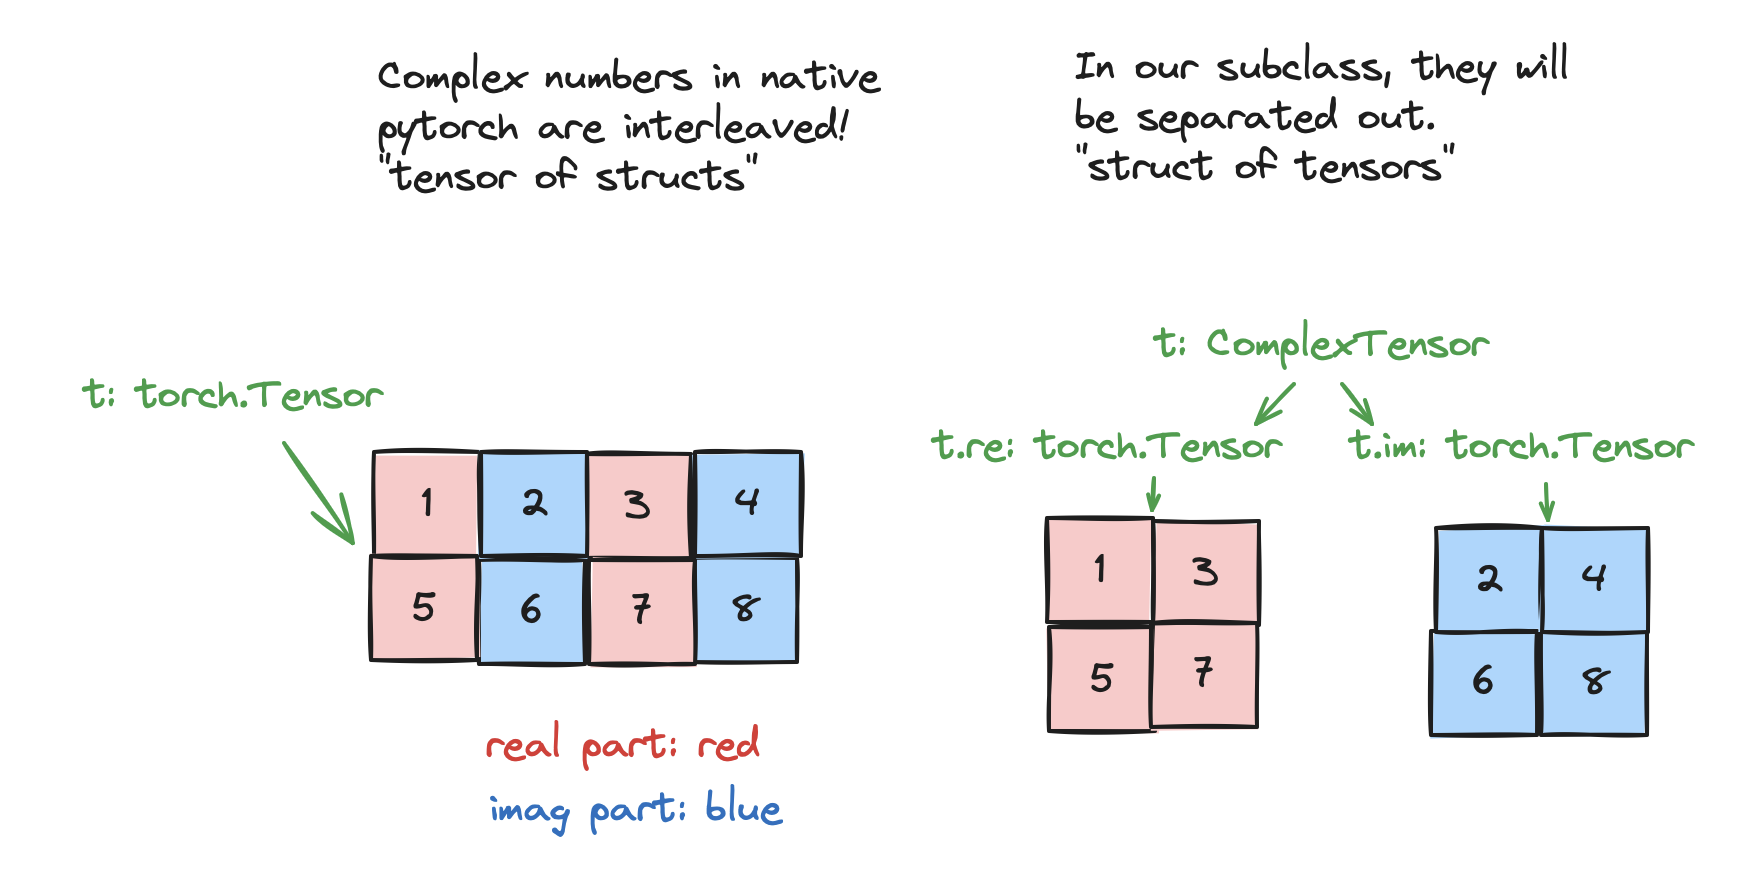

In [ ]:
# We will compare our subclass with the "reference" implementation from pytorch
# Create some reference inputs
a_ref = torch.arange(8, dtype=torch.float32, device='cpu')
a_ref = a_ref.reshape(2, 2, 2).detach().requires_grad_(True)
a_ref_complex = torch.view_as_complex(a_ref)

b_ref = torch.arange(8, dtype=torch.float32, device='cpu')
b_ref = b_ref.reshape(2, 2, 2).detach().requires_grad_(True)
b_ref_complex = torch.view_as_complex(b_ref)

print(a_ref_complex.dtype)
print(a_ref_complex.real.dtype)
print(a_ref_complex.imag.dtype)

print(a_ref_complex.real)
print(a_ref_complex.imag)

torch.complex64
torch.float32
torch.float32
tensor([[0., 2.],
        [4., 6.]], grad_fn=<SelectBackward0>)
tensor([[1., 3.],
        [5., 7.]], grad_fn=<SelectBackward0>)


Next, create a tensor subclass modeling complex numbers.
* Internally holds two tensors (real and imaginary components)
* Operations on a ComplexTensor desugar into operations on each inner tensor

In [ ]:
import torch
import torch.utils._pytree as pytree
from torch.testing._internal.logging_tensor import LoggingTensorMode

POINTWISE_OPS = [
    torch.ops.aten.sin.default,
    torch.ops.aten.cos.default,
    torch.ops.aten.neg.default,
    torch.ops.aten.mul.Tensor,
    torch.ops.aten.add.Tensor,
]

VIEW_OPS = [
    torch.ops.aten.t.default
]

def complex_mm(x, y):
    re = x.re @ y.re - x.im @ y.im
    im = x.re @ y.im + x.im @ y.re
    return ComplexTensor(re=re, im=im)

class ComplexTensor(torch.Tensor):
    def __new__(cls, re, im):
        assert (
            re.device == im.device
            and re.layout == im.layout
            and re.dtype == im.dtype
        )
        res = torch.Tensor._make_wrapper_subclass(  # type: ignore[attr-defined]
            cls,
            size=re.size(),
            strides=re.stride(),  # todo: contiguous only
            storage_offset=0,
            dtype=torch.complex64,  # todo: real to complex dtype
            layout=re.layout,
            device=re.device,
            requires_grad=False,  # todo: autograd support
        )
        res.re = re
        res.im = im
        return res

    def conj(self):
        re = self.re
        im = self.im
        im_neg = torch.neg(im)
        return ComplexTensor(re, im)

    def __torch_dispatch__(self, func, types, args=(), kwargs=None):
        if kwargs is None:
            kwargs = {}
        if func is torch.ops.aten.mm.default:
            assert not kwargs
            x, y = args
            return complex_mm(x, y)
        if func is torch.ops.aten._conj.default:
            im = args[0].im
            re = args[0].re
            neg_im = torch.neg(im)
            return ComplexTensor(re, neg_im)
        if func in POINTWISE_OPS or func in VIEW_OPS:
            args_re = pytree.tree_map_only(ComplexTensor, lambda x: x.re, args)
            args_im = pytree.tree_map_only(ComplexTensor, lambda x: x.im, args)
            out_re = func(*args_re, **kwargs)
            out_im = func(*args_im, **kwargs)
            # only handle single-tensor returns for now
            assert isinstance(out_re, torch.Tensor)
            return ComplexTensor(out_re, out_im)
        raise NotImplementedError(f"todo {func}")

    @staticmethod
    def to_complex(*, re, im):
        return ToComplex.apply(re, im)

    def from_complex(self):
        return FromComplex.apply(self)

    def __tensor_flatten__(self):
        return ["re", "im"], None

    @staticmethod
    def __tensor_unflatten__(inner_tensors, meta, outer_size, outer_stride):
        assert meta is None
        re, im = inner_tensors["re"], inner_tensors["im"]
        return ComplexTensor(re, im)

    def __repr__(self):
        return f"ComplexTensor(real={self.re}, imag={self.im})"

class ToComplex(torch.autograd.Function):
    @staticmethod
    def forward(ctx, re, im):
        return ComplexTensor(re, im)
    @staticmethod
    def backward(ctx, grad_complex):
        return grad_complex.re, grad_complex.im

class FromComplex(torch.autograd.Function):
    @staticmethod
    def forward(ctx, complex):
        return complex.re, complex.im
    @staticmethod
    def backward(ctx, grad_re, grad_im):
        return ComplexTensor(grad_re, grad_im)

In [ ]:
# a_ref and b_ref have their real and imag parts interleaved
# need to separate them out before putting them into our subclass
a_real = a_ref[:, :, 0].clone().detach().requires_grad_()
a_imag = a_ref[:, :, 1].clone().detach().requires_grad_()
b_real = b_ref[:, :, 0].clone().detach().requires_grad_()
b_imag = b_ref[:, :, 1].clone().detach().requires_grad_()

a_complex = ComplexTensor.to_complex(re=a_real, im=a_imag)
b_complex = ComplexTensor.to_complex(re=b_real, im=b_imag)
print(a_complex.re)
print(a_complex.im)

tensor([[0., 2.],
        [4., 6.]], requires_grad=True)
tensor([[1., 3.],
        [5., 7.]], requires_grad=True)


In [ ]:
# Define the function we will run
def fn(a, b):
    tmp = a + b
    out = torch.matmul(tmp, tmp)
    return out * 2

Ensure we get the same outputs when using our tensor subclass implementation, compared to the reference implementation in pytorch

In [ ]:
# Confirm that we get the same results with our subclass
out_ref = fn(a_ref_complex, b_ref_complex)
out_ref = torch.view_as_real(out_ref)
print(out_ref.shape)  # 2, 2, 2
# Grab the real and imag components of our result
out_ref_real = out_ref[:, :, 0]
out_ref_imag = out_ref[:, :, 1]

out_subclass = fn(a_complex, b_complex)
out_real, out_imag = out_subclass.from_complex()

print(torch.allclose(out_ref_real, out_real))
print(torch.allclose(out_ref_imag, out_imag))

torch.Size([2, 2, 2])
True
True


Confirm that we get the same gradients too

In [ ]:
# Confirm that we get proper gradients too!
(out_ref_real + out_ref_imag).sum().backward()
(out_real + out_imag).sum().backward()

# When using native complex types, our grad field
# is a [N, N, 2] tensor with the real and imag parts interleaved
a_ref_grad_real = a_ref.grad[:, :, 0]
a_ref_grad_imag = a_ref.grad[:, :, 1]
print(torch.allclose(a_ref_grad_real, a_real.grad))
print(torch.allclose(a_ref_grad_imag, a_imag.grad))

b_grad_real = a_ref.grad[:, :, 0]
a_grad_imag = a_ref.grad[:, :, 1]
print(torch.allclose(a_ref_grad_real, a_real.grad))
print(torch.allclose(a_ref_grad_imag, a_imag.grad))

True
True
True
True


Now, lets take a look at the graph/output produced by torch.compile at each stage:
* Dynamo
* AOTAutograd
* Inductor

In [ ]:
fn_compiled = torch.compile(fn)

# Just going to show the forward graph for simplicity
x_real = torch.randn(1024, 1024, device='cpu')
x_imag = torch.randn(1024, 1024, device='cpu')
x = ComplexTensor(x_real, x_imag)

y_real = torch.randn(1024, 1024, device='cpu')
y_imag = torch.randn(1024, 1024, device='cpu')
y = ComplexTensor(y_real, y_imag)

Dynamo will trace out the python bytecode of fn() into a graph: we have not desugared our subclass yet!

Some properties of the graph:
* one graph input (the subclass)
* 3 ops (add, matmul, mul), coming directly from fn

In [ ]:
torch._logging.set_logs(graph_code=True)
out = fn_compiled(x, y)
torch._logging.set_logs(graph_code=False)
torch._dynamo.reset()

V0427 00:33:34.747000 135975668621312 torch/_dynamo/output_graph.py:1261] [0/0] [__graph_code] TRACED GRAPH
V0427 00:33:34.747000 135975668621312 torch/_dynamo/output_graph.py:1261] [0/0] [__graph_code]  ===== __compiled_fn_1 =====
V0427 00:33:34.747000 135975668621312 torch/_dynamo/output_graph.py:1261] [0/0] [__graph_code]  /usr/local/lib/python3.10/dist-packages/torch/fx/_lazy_graph_module.py class GraphModule(torch.nn.Module):
V0427 00:33:34.747000 135975668621312 torch/_dynamo/output_graph.py:1261] [0/0] [__graph_code]     def forward(self, L_a_ : __main___ComplexTensor, L_b_ : __main___ComplexTensor):
V0427 00:33:34.747000 135975668621312 torch/_dynamo/output_graph.py:1261] [0/0] [__graph_code]         l_a_ = L_a_
V0427 00:33:34.747000 135975668621312 torch/_dynamo/output_graph.py:1261] [0/0] [__graph_code]         l_b_ = L_b_
V0427 00:33:34.747000 135975668621312 torch/_dynamo/output_graph.py:1261] [0/0] [__graph_code]         
V0427 00:33:34.747000 135975668621312 torch/_dynamo

AOTAutograd will trace **inside** our __torch_dispatch__ implementation, and desugar our subclass.

Some properties of the graph:
* two graph inputs (the "desugared" version of our complex tensor, separate real and imag components)
* several extra mm ops! matmul multiplication on complex tensors can be written as several matrix multiplications over the real and imaginary components.

In [ ]:
torch._logging.set_logs(aot_graphs=True)
out = fn_compiled(x, y)
torch._logging.set_logs(aot_graphs=False)
torch._dynamo.reset()

V0427 00:33:53.422000 135975668621312 torch/_functorch/_aot_autograd/dispatch_and_compile_graph.py:92] [0/0] [__aot_graphs] aot_config id: 1, fw_metadata=ViewAndMutationMeta(input_info=[InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=True), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=True)], output_info=[OutputAliasInfo(output_type=<OutputType.non_alias: 1>, raw_type=<class '__main__.ComplexTensor'>, base_idx=None, dynamic_dims=set(), requires_grad=False, functional_tensor=None)], num_intermediate_bases=0, keep_input_mutations=True, traced_tangents=[], subclass_inp_meta=[SubclassCreationMeta(flat_tensor_start_idx=0, ar

Inductor output: triton code. We got generated triton kernels for our complex number code, without having to teach inductor about complex numbers.

In [ ]:
torch._logging.set_logs(output_code=True)
out = fn_compiled(x, y)
torch._logging.set_logs(output_code=False)
torch._dynamo.reset()

V0427 00:34:05.946000 135975668621312 torch/_inductor/graph.py:1582] [0/0] [__output_code] Output code: 
V0427 00:34:05.946000 135975668621312 torch/_inductor/graph.py:1582] [0/0] [__output_code] 
V0427 00:34:05.946000 135975668621312 torch/_inductor/graph.py:1582] [0/0] [__output_code] # AOT ID: ['2_inference']
V0427 00:34:05.946000 135975668621312 torch/_inductor/graph.py:1582] [0/0] [__output_code] from ctypes import c_void_p, c_long
V0427 00:34:05.946000 135975668621312 torch/_inductor/graph.py:1582] [0/0] [__output_code] import torch
V0427 00:34:05.946000 135975668621312 torch/_inductor/graph.py:1582] [0/0] [__output_code] import math
V0427 00:34:05.946000 135975668621312 torch/_inductor/graph.py:1582] [0/0] [__output_code] import random
V0427 00:34:05.946000 135975668621312 torch/_inductor/graph.py:1582] [0/0] [__output_code] import os
V0427 00:34:05.946000 135975668621312 torch/_inductor/graph.py:1582] [0/0] [__output_code] import tempfile
V0427 00:34:05.946000 135975668621312 t